# Generalized Autoregressive Model

Using PyMC3's Autoregressive Process implementation
- API: https://docs.pymc.io/api/distributions/timeseries.html
- Example: https://docs.pymc.io/notebooks/AR.html

Example data: `boston_medical_center_2020-04-29_to_2020-07-06.csv`
- Column: `hospitalized_total_covid_patients_suspected_and_confirmed_including_icu`

## Goal
Given a series of past daily counts (admissions, census, etc.) $$y_1, y_2, ..., y_T$$

Assuming $T$ is today, want to predict counts $$y_{T+1}, y_{T+2}, ..., y_{T+F}$$ for $F$ days ahead.

## Model

Suppose that $y$ is Poisson distributed over the exponential of a latent time series modeled by an autoregressive process with $W$ lags, i.e., 

$$y_t \sim \text{Poisson}( \exp(f_t) )$$

where for each $t$, $f_t$ is a linear combination of the past $W$ timesteps, i.e.,

$$f_t \sim N(\beta_0 + \beta_1 * f_{t-1} + ... + \beta_W * f_{t-W}, \tau^2)$$

(Use small $\sigma$ for numerical stability.)

## Parameters and their Priors

Bias weight $$\beta_0 \sim N(0,0.1)$$
Weight on most recent timestep $$\beta_1 \sim N(1,0.1)$$
Weights on all other previous timesteps $$\beta_2, ..., \beta_W \sim N(0,0.1)$$
Standard deviation $$\tau \sim \text{HalfNormal}(0.1)$$

## Training

Let the subscript "past" represent indices $1$ through $T$, and the subscript "future" represent indices $T+1$ through $T+F$.

1. Define $f$ as an AR process in PyMC3. Set `rho` to be [$\beta_0, \beta_1, ..., \beta_W$]. Set `shape` to be $T+F$ so that it encompasses both $f_\text{past}$ and $f_\text{future}$.
1. Define the observed variable $$y_\text{past} \sim \text{Poisson}(\mu = \exp(f_\text{past}))$$ Set `mu` to be the exponential of the first $T$ $f$ values, i.e., only $f_\text{past}$.
1. Use PyMC3's MCMC to draw samples from the posterior $$\beta^s, f^s \sim p(\beta, f_\text{past}, f_\text{future} | y_\text{past})$$

In [1]:
%matplotlib inline
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import theano.tensor as tt

In [2]:
df = pd.read_csv('../mass_dot_gov_datasets/boston_medical_center_2020-04-29_to_2020-07-06.csv')
y = df['hospitalized_total_covid_patients_suspected_and_confirmed_including_icu'].astype(float)
T = len(y)

In [3]:
W = 2
F = 7

with pm.Model() as model:
    bias = pm.Normal('beta[0]', mu=0, sigma=0.1)
    beta_recent = pm.Normal('beta[1]', mu=1, sigma=0.01)
    rho = [bias, beta_recent]
    for i in range(2, W+1):
        beta = pm.Normal(f'beta[{i}]', mu=0, sigma=0.01)
        rho.append(beta)
    tau = pm.HalfNormal('tau', sigma=0.1)
    f = pm.AR('f', rho, sigma=tau, constant=True, shape=T+F)
    
    y_past = pm.Poisson('y_past', mu=tt.exp(f[:T]), observed=y)
    
    y_logp = pm.Deterministic('y_logp', y_past.logpt)

In [4]:
with model:
    trace = pm.sample(5000, tune=1000, target_accept=0.99, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, tau, beta[2], beta[1], beta[0]]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [02:55<00:00, 136.40draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [5]:
summary = pm.summary(trace)['mean'].to_dict()
for i in range(W+1):
    print(f'beta[{i}]', summary[f'beta[{i}]'])
print('tau', summary['tau'])
print('\nTraining score:')
print('Chain 1:', np.log(np.mean(np.exp(trace.get_values('y_logp', chains=0)))) / T)
print('Chain 2:', np.log(np.mean(np.exp(trace.get_values('y_logp', chains=1)))) / T)
print('Chain 3:', np.log(np.mean(np.exp(trace.get_values('y_logp', chains=2)))) / T)
print('Chain 4:', np.log(np.mean(np.exp(trace.get_values('y_logp', chains=3)))) / T)

beta[0] -0.007
beta[1] 0.997
beta[2] -0.003
tau 0.048

Training score:
Chain 1: -3.3927505830477993
Chain 2: -3.3876572916486825
Chain 3: -3.389032124706578
Chain 4: -3.3895648593740404


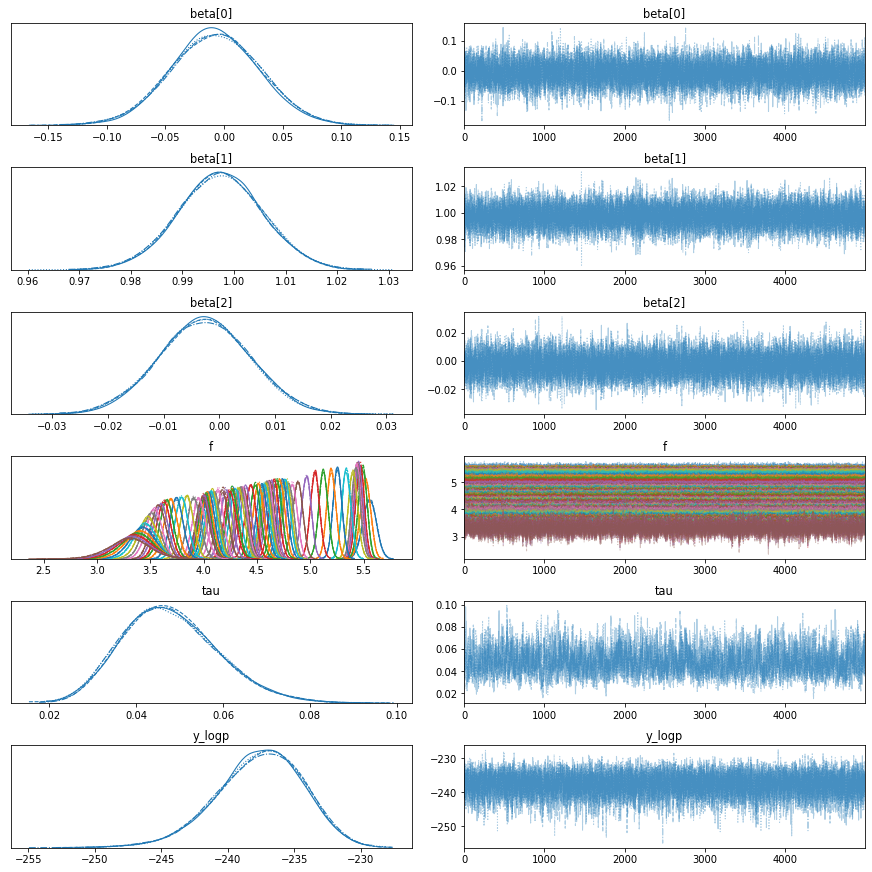

In [6]:
pm.traceplot(trace);

## Forecasting Procedure

1. Define a predictive distribution $$y_\text{future} \sim \text{Poisson}(\mu=\exp(f_\text{future}))$$
1. Use PyMC3's `sample_posterior_predictive` and the posterior samples collected during training to produce forecasts.
    - Note: It is not recommended to modify the number of `samples` as if it is too small, some chains may not be represented in the posterior predictive sample. Defaults to one posterior predictive sample per posterior sample, that is, the number of draws times the number of chains.

In [7]:
with model:
    y_future = pm.Poisson('y_future', mu=tt.exp(f[-F:]), shape=F)
    forecasts = pm.sample_posterior_predictive(trace, vars=[y_future], random_seed=42)
    
samples = forecasts['y_future']

100%|██████████| 20000/20000 [00:08<00:00, 2308.25it/s]


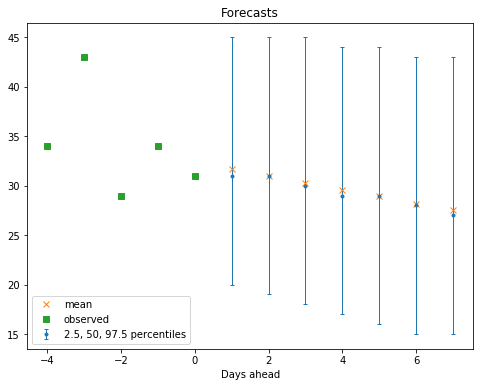

In [8]:
low = np.zeros(F)
high = np.zeros(F)
mean = np.zeros(F)
median = np.zeros(F)

for i in range(F):
    low[i] = np.percentile(samples[:,i], 2.5)
    high[i] = np.percentile(samples[:,i], 97.5)
    median[i] = np.percentile(samples[:,i], 50)
    mean[i] = np.mean(samples[:,i])

plt.figure(figsize=(8,6))
x_future = np.arange(1,F+1)
plt.errorbar(x_future, median,
             yerr=[median-low, high-median],
             capsize=2, fmt='.', linewidth=1,
             label='2.5, 50, 97.5 percentiles');
plt.plot(x_future, mean, 'x', label='mean');
x_past = np.arange(-4,1)
plt.plot(x_past, y[-5:], 's', label='observed')
plt.legend();
plt.title('Forecasts');
plt.xlabel('Days ahead');

## Heldout Scoring Procedure

1. Partition the data to treat the first 80% as $y_\text{past}$ and the last 20% as $y_\text{future}$. We'll use $y_\text{past}$ as the training set, and $y_\text{future}$ as the validation set.
1. Train the model using $y_\text{past}$.
1. Define the predictive distribution $$y_\text{future} \sim \text{Poisson}(\mu = \exp(f_\text{future}))$$ Set `mu` to be the exponential of the last $F$ $f$ values, i.e., only $f_\text{future}$. Set `observed` to be the observed $y_\text{future}$ values.
1. Define a `Deterministic` distribution that computes the logp of the observed variable $y_\text{future}$.
1. Use `sample_posterior_predictive` to compute the log probability of $y_\text{future}$ conditioned on each posterior sample {$\beta^s, \tau^s, f^s$}.
1. Use Monte Carlo integration to estimate the log probability of the heldout set: $$\log p(y_\text{future} | y_\text{past}) = \log \frac{1}{S} \sum_{s=1}^S p(y_\text{future} | \beta^s, \tau^s, f^s, y_\text{past})$$

In [9]:
df = pd.read_csv("../mass_dot_gov_datasets/boston_medical_center_2020-04-29_to_2020-07-06.csv")
y = df['hospitalized_total_covid_patients_suspected_and_confirmed_including_icu'].astype(float)

T = int(.8 * len(y))
y_tr = y[:T]
y_va = y[T:]
F = len(y_va)

In [10]:
W = 2

with pm.Model() as model:
    bias = pm.Normal('beta[0]', mu=0, sigma=0.1)
    beta_recent = pm.Normal('beta[1]', mu=1, sigma=0.01)
    rho = [bias, beta_recent]
    for i in range(2, W+1):
        beta = pm.Normal(f'beta[{i}]', mu=0, sigma=0.01)
        rho.append(beta)
    tau = pm.HalfNormal('tau', sigma=0.1)
    f = pm.AR('f', rho, sigma=tau, constant=True, shape=T+F)

    y_past = pm.Poisson('y_past', mu=tt.exp(f[:T]), observed=y_tr)
    y_logp = pm.Deterministic('y_logp', y_past.logpt)

In [11]:
with model:
    trace = pm.sample(5000, tune=1000, target_accept=0.99, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f, tau, beta[2], beta[1], beta[0]]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [03:24<00:00, 117.54draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [12]:
summary = pm.summary(trace)['mean'].to_dict()
for i in range(W+1):
    print(f'beta[{i}]', summary[f'beta[{i}]'])
print('\nTraining score:')
print('Chain 1:', np.log(np.mean(np.exp(trace.get_values('y_logp', chains=0)))) / T)
print('Chain 2:', np.log(np.mean(np.exp(trace.get_values('y_logp', chains=1)))) / T)
print('Chain 3:', np.log(np.mean(np.exp(trace.get_values('y_logp', chains=2)))) / T)
print('Chain 4:', np.log(np.mean(np.exp(trace.get_values('y_logp', chains=3)))) / T)

beta[0] 0.013
beta[1] 0.996
beta[2] -0.005

Training score:
Chain 1: -3.469270107796615
Chain 2: -3.4655448651413354
Chain 3: -3.467376333534083
Chain 4: -3.4704744174956583


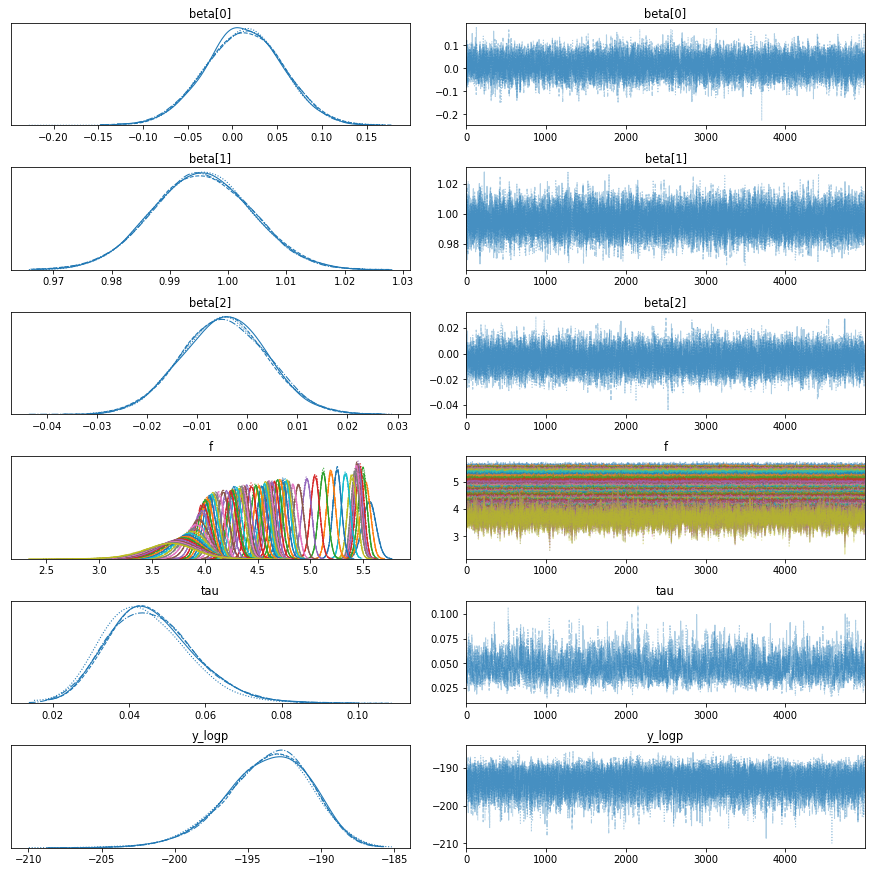

In [13]:
pm.traceplot(trace);

In [14]:
with model:
    y_future = pm.Poisson('y_future', mu=tt.exp(f[T:]), observed=y_va)
    lik = pm.Deterministic('lik', y_future.logpt)
    logp_list = pm.sample_posterior_predictive(trace, vars=[lik], keep_size=True)

100%|██████████| 20000/20000 [00:05<00:00, 3742.06it/s]


In [15]:
print('Heldout score:')
chain_0 = logp_list['lik'][0]
chain_1 = logp_list['lik'][1]
chain_2 = logp_list['lik'][2]
chain_3 = logp_list['lik'][3]
print(f'Chain 0: {np.log(np.mean(np.exp(chain_0))) / F}')
print(f'Chain 1: {np.log(np.mean(np.exp(chain_1))) / F}')
print(f'Chain 2: {np.log(np.mean(np.exp(chain_2))) / F}')
print(f'Chain 3: {np.log(np.mean(np.exp(chain_3))) / F}')

Heldout score:
Chain 0: -3.338827205082324
Chain 1: -3.3330257276116266
Chain 2: -3.338423078811889
Chain 3: -3.332682861495456


In [16]:
with model:
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f[T:]), shape=F)
    forecasts = pm.sample_posterior_predictive(trace, vars=[y_pred], random_seed=42)

samples = forecasts['y_pred']

100%|██████████| 20000/20000 [00:08<00:00, 2249.84it/s]


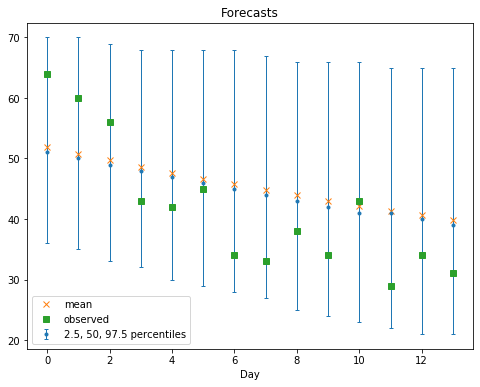

In [17]:
low = np.zeros(F)
high = np.zeros(F)
mean = np.zeros(F)
median = np.zeros(F)

for i in range(F):
    low[i] = np.percentile(samples[:,i], 2.5)
    high[i] = np.percentile(samples[:,i], 97.5)
    median[i] = np.percentile(samples[:,i], 50)
    mean[i] = np.mean(samples[:,i])

plt.figure(figsize=(8,6))
xticks = np.arange(F)
plt.errorbar(xticks, median,
             yerr=[median-low, high-median],
             capsize=2, fmt='.', linewidth=1,
             label='2.5, 50, 97.5 percentiles');
plt.plot(xticks, mean, 'x', label='mean');
plt.plot(xticks, y_va, 's', label='observed');
plt.legend();
plt.title('Forecasts');
plt.xlabel('Day');